<a href="https://colab.research.google.com/github/dssaenzml/simCLR_ML/blob/main/SimCLR_OCT_Classifier_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SimCLR Feature Extractor + OCT CLassifier ( Pytorch Lightning )

List of full videos is here:    

https://www.youtube.com/playlist?list=PLaMu-SDt_RB4k8VXiB3hOdsn0Y3GoXo1k

Pretrained simCLR2: https://console.cloud.google.com/storage/browser/simclr-checkpoints/simclrv2/pretrained?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
! pip install git+https://github.com/PyTorchLightning/pytorch-lightning
! pip install git+https://github.com/PytorchLightning/pytorch-lightning-bolts.git@master --upgrade
! pip install image
! pip install comet-ml
! pip install captum
! pip install Pillow

# use requirements.txt provided on WA
# ! pip install -r /content/drive/MyDrive/Colab_Notebooks/OCT_Scans/requirements.txt
# restart kernel once done 

## Importing libraries and Dataset

In [5]:
# comet
from comet_ml import Experiment
from pytorch_lightning.loggers import CometLogger

# ----- general import -----
import torch
import pytorch_lightning as pl
import zipfile
import os
import pandas as pd
import numpy as np
import torch
import torchvision
from datetime import datetime

# ----- dataloader imports -----
# from flash import download_data
# from  pl_bolts.datamodules.async_dataloader import AsynchronousLoader
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# ----- datamodule imports -----
from torch.utils.data import random_split
# from torch.utils.data import RandomSampler
import matplotlib.pyplot as plt
import math

# ----- data transforms imports -----
import torchvision.transforms as transforms
import torchvision.transforms.functional as tvf

# ----- model imports -----
from pl_bolts.models.self_supervised import SimCLR
from pytorch_lightning.callbacks import Callback
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from pl_bolts.models import LinearRegression, LogisticRegression
import torchvision.models as models
from argparse import Namespace
from pytorch_lightning.callbacks import LearningRateMonitor

# ----- evaluation imports -----
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,RocCurveDisplay,plot_roc_curve,auc
from pytorch_lightning.metrics import ROC
# ----- check kernel device -----
# if you get CPU, change Runtime type to GPU. Top menu: Runtime > Change Runtime type > GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
#load OCT data - $$$ keep in mind this action incurs a cost on AWS $$$
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
# zipurl = 'https://ml701.s3.me-south-1.amazonaws.com/OCT2017_M.zip' #to be updated
# with urlopen(zipurl) as zipresp:
#     with ZipFile(BytesIO(zipresp.read())) as zfile:
#         zfile.extractall('data/')
# zipurl = 'https://ml701.s3.me-south-1.amazonaws.com/OCT_D.zip' #to be updated
# with urlopen(zipurl) as zipresp:
#     with ZipFile(BytesIO(zipresp.read())) as zfile:
#         zfile.extractall('/content/drive/MyDrive/Colab_Notebooks/OCT_Scans/')

# download_data("https://ml701.s3.me-south-1.amazonaws.com/OCT2017_M.zip", "data/")

In [7]:
#class map
idx_to_label = {
    0: 'NORMAL',
    1: 'CNV',
    2: 'DME',
    3: 'DRUSEN'
}

label_list = []
for key, value in idx_to_label.items():
    temp = value
    label_list.append(temp)
print(label_list)

#fix state for data seed
random_state = 6

num_of_classes = int(len(idx_to_label))
frac_train_images = 1 # update 
batch_size = 64 # update
optimizer = 'Adagrad' # update

#download data from step above before setting root_dir
root_dir = '/content/drive/MyDrive/Colab_Notebooks/OCT_Scans/OCT2017_M'
root_dir_test = '/content/drive/MyDrive/Colab_Notebooks/OCT_Scans/OCT2017_M'
# root_dir_test = '/content/drive/MyDrive/Colab_Notebooks/OCT_Scans/OCT_D'

#explore dataset
total_train = pd.read_csv(f"{root_dir}/train.csv")
data = total_train.sample(frac=frac_train_images, random_state=random_state)
print(f"total train data size: {total_train.shape}, sample train data size: {data.shape}")
data.head()

['NORMAL', 'CNV', 'DME', 'DRUSEN']
total train data size: (5200, 2), sample train data size: (5200, 2)


,image_id,label
134,CNV-103044-37.jpeg,1
521,CNV-154835-89.jpeg,1
614,CNV-163081-172.jpeg,1
4523,NORMAL-285896-14.jpeg,0
3417,DRUSEN-525301-3.jpeg,3


### Defining Dataloader and Transformer

In [8]:
#dataset
class OCTDataset(Dataset):
    """ OCT Dataset """
    def __init__(self, root_dir, root_dir_test, frac_train_images=1, transform=None, stage=False, random_state=1):
        if stage: 
            csv_output = pd.read_csv(os.path.join(root_dir_test, "test.csv"))
            self.images_dir = os.path.join(root_dir_test, "test")
        else:
            total_csv_output = pd.read_csv(os.path.join(root_dir, "train.csv"))
            csv_output = total_csv_output.sample(frac=frac_train_images, 
                                                 random_state=random_state)
            self.images_dir = os.path.join(root_dir, "train")

        self.image_urls = np.asarray(csv_output["image_id"])
        self.labels = np.asarray(csv_output["label"])
        self.transform = transform
        
    def __len__(self):
        return len(self.image_urls)
    
    def __getitem__(self, idx):
        # Get and load image
        image_path = os.path.join(self.images_dir, self.image_urls[idx])
        image = Image.open(image_path)
        # Perform transforms if any
        if self.transform:
            image = self.transform(image)
        # Get label
        label = self.labels[idx]   
        return image, label

In [9]:
#datamodule
class OCTDataModule(pl.LightningDataModule):
    """ OCT DataModule for Lightning """
    def __init__(self, root_dir, root_dir_test, frac_train_images=1, transform=None, batch_size=32, random_state=1):
        super().__init__()
        self.batch_size = batch_size
        self.root_dir = root_dir
        self.root_dir_test = root_dir_test
        self.transform = transform
        self.frac_train_images = frac_train_images
        self.random_state = random_state
        
    def setup(self, stage=None):
        oct_full = OCTDataset(root_dir=self.root_dir, 
                              root_dir_test=self.root_dir_test,
                              transform=self.transform, 
                              frac_train_images=self.frac_train_images, 
                              random_state=self.random_state)
        train_data_len = math.floor(len(oct_full) * 0.7)
        val_data_len = len(oct_full) - train_data_len
        # Create train and validation datasets
        self.oct_train, self.oct_val = random_split(oct_full, 
                                                    [train_data_len, 
                                                     val_data_len], 
                                                    generator=torch.Generator().manual_seed(random_state))
        
        # Create test dataset
        self.oct_test = OCTDataset(root_dir=self.root_dir, 
                                   root_dir_test=self.root_dir_test,
                                   transform=self.transform, stage=True)

    def train_dataloader(self):
        return DataLoader(self.oct_train, batch_size=self.batch_size,
                          num_workers=12)
    
    def val_dataloader(self):
        return DataLoader(self.oct_val, batch_size=self.batch_size, 
                          num_workers=12)
    
    def test_dataloader(self):
        return DataLoader(self.oct_test, batch_size=self.batch_size, 
                          num_workers=12)

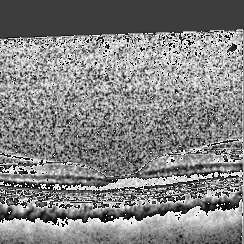

In [10]:
#transforms on OCT data
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    # ImageNet Normalization
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
    ])

random_state = 6
num_of_classes = 4

# update batch_size: 32, 64, 128
oct_data = OCTDataModule(root_dir=root_dir, root_dir_test=root_dir_test, 
                         transform=transform, batch_size=batch_size, 
                         frac_train_images=frac_train_images, 
                         random_state=random_state)
oct_data.setup()

ds_train = oct_data.oct_train
tvf.to_pil_image(ds_train[6][0][0])

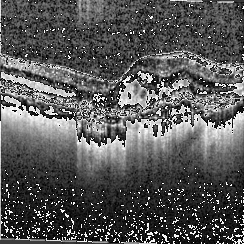

In [11]:
ds_test = oct_data.oct_test
tvf.to_pil_image(ds_test[6][0][0])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning:

This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


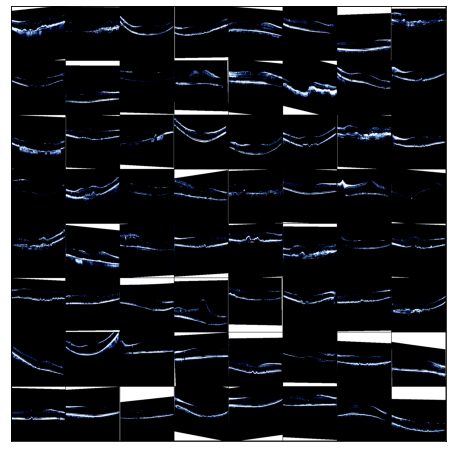

In [12]:
train_dl = oct_data.train_dataloader()
batch = next(iter(train_dl))[0]
def show_images(images, nmax=32):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(torchvision.utils.make_grid(images, nrow=8).permute(1, 2, 0))
show_images(batch)

## Fine-tuning & Classifier

In [15]:
# unfreeze params post warm-up.  Can be used with any model.
class UnFreezeCallback(Callback): 
  def on_epoch_end(self, trainer, pl_module):
    if trainer.current_epoch == 10:
      pl_module.base_model.unfreeze()

# TODO fix this - figure out a way to log embeddings with callbacks
class CometLogCallback(Callback):
    def on_epoch_end(self, trainer, pl_module):
      pl_module.logger.experiment.log_embedding(pl_module.reps, label_list)

In [16]:
# model
# self.accuracy requires PL 1.1.8 https://github.com/PyTorchLightning/pytorch-lightning-bolts/issues/551
# TODO: add attention map implementation. # https://captum.ai/tutorials/Resnet_TorchVision_Interpret
# TODO: upload images and labels. comet.ml log_image
# TODO: Embeddings map and PCA. # https://www.comet.ml/docs/user-interface/embeddings/#logging-embeddings

class OCTModel(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        hparams = Namespace(**hparams) if isinstance(hparams, dict) else hparams
        self.save_hyperparameters(hparams)

        # load simCLR pre-trained on imagenet for feature extraction  
        self.base_model = SimCLR.load_from_checkpoint(self.hparams.embeddings_path, 
                                                 strict=False)     
        # Set some params
        self.tune = self.hparams.tune
        # self.accuracy = pl.metrics.Accuracy()
        num_target_classes = self.hparams.n_classes
        
        #freeze
        if self.hparams.freeze_base:
            self.base_model.eval()  

        # Use the pretrained simclr model representations to classify oct. 
        self.classifier = nn.Sequential(
            nn.Linear(self.base_model.encoder.fc.in_features, 
                      self.base_model.encoder.fc.in_features),
            nn.ReLU(),
            nn.Linear(self.base_model.encoder.fc.in_features, 
                      num_target_classes if num_target_classes > 2 else 1),
        )
        
        # Create loss function
        self.loss_fn = torch.nn.CrossEntropyLoss()
    
    def configure_optimizers(self):
        # https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.OneCycleLR
        # optimizers: Adagrad, SGD, Adam, LBFGS, RMSProp, Adamax
        # update
        optimizer = torch.optim.Adagrad(self.parameters(), lr=self.hparams.learning_rate,) 
        lr_scheduler = {'scheduler': torch.optim.lr_scheduler.OneCycleLR(
                                        optimizer,
                                        max_lr=self.hparams.learning_rate,
                                        steps_per_epoch=int(self.hparams.steps_per_epoch),
                                        epochs=self.hparams.max_epochs,
                                        anneal_strategy="linear",
                                        final_div_factor = 30,
                                        cycle_momentum=False
                                    ),
                        'name': 'learning_rate',
                        'interval':'step',
                        'frequency': 1}
        return [optimizer], [lr_scheduler]
         
    def forward(self, input_data):
        representations = self.base_model(input_data)
        preds = self.classifier(representations)
        # self.reps = representations
        return preds
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        predictions = self.forward(x)
        loss = self.loss_fn(predictions, y)
        self.log('train_loss', loss)
        return {'loss': loss}
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        predictions = self.forward(x)
        loss = self.loss_fn(predictions, y)
        self.log('val_loss', loss)

### Finding best Learning rate parameter for initialization

In [52]:
# simCLR weight path
weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
hparams = Namespace(
    learning_rate=1e-3,
    freeze_base=True,
    tune=True,
    max_epochs=15,
    steps_per_epoch = len(oct_data.train_dataloader()),
    n_classes=num_of_classes,
    embeddings_path=weight_path,
    batch_size=batch_size,
    optimizer=optimizer,
    arch='resnet50',
    frac_train_images=frac_train_images
)

#init model
model = OCTModel(hparams)

#tune
trainer = pl.Trainer(gpus=1)
lr_finder = trainer.tuner.lr_find(model,datamodule=oct_data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning:

This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | base_model | SimCLR           | 30.0 M
1 | classifier | Sequential       | 4.2 M 
2 | loss_fn    | CrossEntropyLoss | 0     
------------------------------------------------
34.2 M    Trainable params
0         Non-trainable params
34.2 M    Total params
136.897   Total estimated model params size (MB)


Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


suggested learning rate:  0.002754228703338169


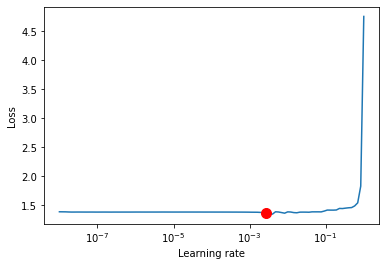

In [53]:
# Inspect results
lr_finder.plot(show=False, suggest=True)
suggested_lr = lr_finder.suggestion()
print('suggested learning rate: ', suggested_lr)


### Running Classifier model with best initialization parameters

In [54]:
# Overwrite lr and create new model
weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
hparams = Namespace(
    learning_rate=suggested_lr,
    freeze_base=True,
    tune=False,
    max_epochs=15,
    steps_per_epoch = len(oct_data.train_dataloader()),
    n_classes=num_of_classes,
    embeddings_path=weight_path,
    batch_size=batch_size,
    optimizer=optimizer,
    arch='resnet50',
    frac_train_images=frac_train_images
)

model_tuned = OCTModel(hparams)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning:

This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



In [55]:
#init comet.ml logger

experiment_num = 1
date=datetime.today().strftime('%Y%m%d')
experiment_name=f"OCT_classifier_{int(frac_train_images * 100)}_{optimizer}_{experiment_num}_{date}" 
project_name="ml701-ssl-project"

lr_logger = LearningRateMonitor(logging_interval='step')
comet_logger = CometLogger(
    api_key="oqnsyupYtRnpFlgmW4zBl7XxC",
    workspace="abdusah-mbzuai",
    project_name=project_name,
    experiment_name=experiment_name
)
print(f"{experiment_name} comet.ml project: {project_name}")

# checkpoint callback - log at each epoch
checkpoint_callback=pl.callbacks.ModelCheckpoint(
    dirpath=experiment_name + '_ckp',
    monitor='val_loss',
    filename='{epoch}-{train_loss:.2f}-{val_loss:.2f}'    
)

# Define the trainer for our classifier and fit OCT data
trainer = pl.Trainer(max_epochs=hparams.max_epochs,
                     progress_bar_refresh_rate=20,
                     gpus=1,
                     logger=comet_logger,
                     callbacks=[checkpoint_callback, 
                                UnFreezeCallback(), 
                                lr_logger ])
trainer.fit(model_tuned, datamodule=oct_data)

#save checkpoint with weights
checkpoint_file="octmodel.ckpt"
torch.save(model_tuned.state_dict(), 'octmodel')
trainer.save_checkpoint(checkpoint_file)

# save model to comet
# comet_logger.experiment.log_asset(checkpoint_file, step="classifier_training")
comet_logger.experiment.log_model(experiment_name, './octmodel')
comet_logger.experiment.log_model(experiment_name, './octmodel.ckpt')

CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


OCT_classifier_100_Adagrad_1_20210421 comet.ml project: ml701-ssl-project


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/abdusah-mbzuai/ml701-ssl-project/0b2db85bbc2848faad16a9baabc2d91e


  | Name       | Type             | Params
------------------------------------------------
0 | base_model | SimCLR           | 30.0 M
1 | classifier | Sequential       | 4.2 M 
2 | loss_fn    | CrossEntropyLoss | 0     
------------------------------------------------
34.2 M    Trainable params
0         Non-trainable params
34.2 M    Total params
136.897   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning:

This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/abdusah-mbzuai/ml701-ssl-project/0b2db85bbc2848faad16a9baabc2d91e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     learning_rate [17] : (2.6651055133276348e-05, 0.002686963000368188)
COMET INFO:     loss [103]         : (0.00013537744234781712, 1.3851757049560547)
COMET INFO:     train_loss [17]    : (0.00015156557492446154, 0.18825800716876984)
COMET INFO:     val_loss [15]      : (0.10809170454740524, 0.24533087015151978)
COMET INFO:   Others:
COMET INFO:     Name : OCT_classifier_100_Adagrad_1_20210421
COMET INFO:   Parameters:
COMET INFO:     arch              : resnet50
COMET INFO:     batch_size        : 64
COMET INFO:     embeddings_path   : https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_ima

{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=0ded354ab7334badb435ce30fc564022&experimentKey=0b2db85bbc2848faad16a9baabc2d91e',
 'assetId': '0ded354ab7334badb435ce30fc564022',
 'web': 'https://www.comet.ml/api/asset/download?assetId=0ded354ab7334badb435ce30fc564022&experimentKey=0b2db85bbc2848faad16a9baabc2d91e'}

## Evaluation

In [14]:
def evaluate(data_loader,module):
    with torch.no_grad():
        module.eval() 
        print('set model eval mode')
        true_y, pred_y, score_y = [], [], []
        print('ready')
        for i, _batch in enumerate(data_loader):       
            x, y = _batch
            y_score = module(x)    
            y_pred = torch.argmax(y_score, dim=1)
            true_y.extend(y)
            pred_y.extend(y_pred)
            score_y.extend(y_score)
            print(f"batch {i} done")
        print('eval done')
        return true_y, pred_y, score_y

In [57]:
# Evaluate predictions on test data
ds_test = oct_data.test_dataloader()
true_y, pred_y, score_y = evaluate(ds_test, model_tuned)

set model eval mode
ready


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning:

This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



batch 0 done
batch 1 done
batch 2 done
batch 3 done
batch 4 done
batch 5 done
batch 6 done
batch 7 done
batch 8 done
batch 9 done
batch 10 done
batch 11 done
batch 12 done
batch 13 done
batch 14 done
batch 15 done
eval done


In [58]:
print(idx_to_label)
conf_matrix = confusion_matrix(true_y, pred_y)
print(conf_matrix)
comet_logger.experiment.log_confusion_matrix(
    labels=[idx_to_label[0],idx_to_label[1],idx_to_label[2],idx_to_label[3]],
    matrix=conf_matrix)

{0: 'NORMAL', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}
[[246   0   2   2]
 [  0 245   2   3]
 [  0   3 246   1]
 [  1   4   0 245]]


{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=fed3a1a4ccf243e0a4c4cfa074d1c431&experimentKey=0b2db85bbc2848faad16a9baabc2d91e',
 'assetId': 'fed3a1a4ccf243e0a4c4cfa074d1c431',
 'web': 'https://www.comet.ml/api/asset/download?assetId=fed3a1a4ccf243e0a4c4cfa074d1c431&experimentKey=0b2db85bbc2848faad16a9baabc2d91e'}

In [59]:
report = classification_report(true_y, pred_y, digits=3)
print(report)
comet_logger.experiment.log_text(report)


              precision    recall  f1-score   support

           0      0.996     0.984     0.990       250
           1      0.972     0.980     0.976       250
           2      0.984     0.984     0.984       250
           3      0.976     0.980     0.978       250

    accuracy                          0.982      1000
   macro avg      0.982     0.982     0.982      1000
weighted avg      0.982     0.982     0.982      1000



{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=d8ed782dbeda46e1924a6a98b2b667b3&experimentKey=0b2db85bbc2848faad16a9baabc2d91e',
 'assetId': 'd8ed782dbeda46e1924a6a98b2b667b3',
 'web': 'https://www.comet.ml/api/asset/download?assetId=d8ed782dbeda46e1924a6a98b2b667b3&experimentKey=0b2db85bbc2848faad16a9baabc2d91e'}

In [ ]:
# TODO: show ROC curve per class or multi-class ROC

# fpr, tpr, thresholds = roc_curve(true_y, pred_y, pos_label=2)
# roc_auc = auc(fpr, tpr)

# roc = ROC(num_classes=4)
# fpr, tpr, thresholds = roc(np.array(score_y), np.array(pred_y))

# display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc,                                          estimator_name='example estimator')
# display.plot()  
# plt.show() 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


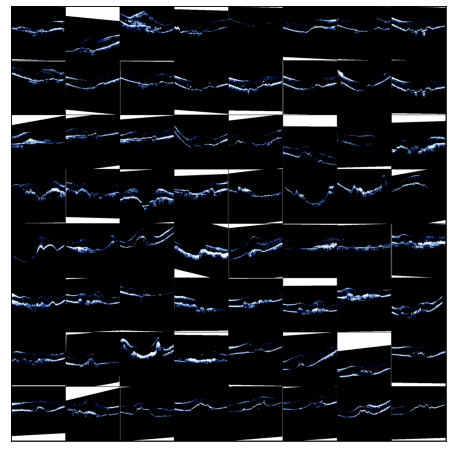

In [ ]:
test_dl = oct_data.test_dataloader()
batch = next(iter(test_dl))[0]
def show_images(images, nmax=32):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(torchvision.utils.make_grid(images, nrow=8).permute(1, 2, 0))
  # comet_logger.experiment.log_image(images, name=f"test_sample")
show_images(batch)


In [60]:
comet_logger.experiment.log_image('test_samples.png', name="test_samples_grid")
comet_logger.experiment.log_image('train_samples.png', name="train_samples_grid")

COMET ERROR: We failed to read file test_samples.png for uploading.
Please double-check the file path and permissions
COMET ERROR: We failed to read file train_samples.png for uploading.
Please double-check the file path and permissions


In [61]:
# end experiment - must be called after you use experiment logger
comet_logger.experiment.end()

COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/abdusah-mbzuai/ml701-ssl-project/0b2db85bbc2848faad16a9baabc2d91e
COMET INFO:   Others:
COMET INFO:     Name : OCT_classifier_100_Adagrad_1_20210421
COMET INFO:   Uploads [count]:
COMET INFO:     confusion-matrix  : 1
COMET INFO:     model-element [2] : 2
COMET INFO:     text-sample       : 1
COMET INFO: -----------------------------------
COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s)


# Load Trained Model
Download latest model from registry https://www.comet.ml/abdusah-mbzuai/model-registry/oct-classifier-model

In [17]:
suggested_lr = 0.0019054607179632484
weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
hparams = Namespace(
    learning_rate=suggested_lr,
    freeze_base=True,
    tune=False,
    max_epochs=15,
    steps_per_epoch = len(oct_data.train_dataloader()),
    n_classes=num_of_classes,
    embeddings_path=weight_path,
    batch_size=batch_size,
    optimizer=optimizer,
    arch='resnet50',
    frac_train_images=frac_train_images
)
model_loaded = OCTModel(hparams)
# import requests
# r = requests.get('https://www.comet.ml/api/rest/v2/registry-model/item/download?workspaceName=abdusah-mbzuai&modelName=oct-classifier-model&version=1.3.0', headers={'Authorization': 'oqnsyupYtRnpFlgmW4zBl7XxC'})

model_loaded.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/OCT_Scans/octmodel'))
# model_loaded


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning:

This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

Downloading: "https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt" to /root/.cache/torch/hub/checkpoints/simclr_imagenet.ckpt


<All keys matched successfully>

## Test loaded model

In [18]:
def evaluate(data_loader,module):
    with torch.no_grad():
        module.eval() 
        print('set model eval mode')
        true_y, pred_y, score_y = [], [], []
        print('ready')
        for i, _batch in enumerate(data_loader):       
            x, y = _batch
            y_score = module(x)    
            y_pred = torch.argmax(y_score, dim=1)
            true_y.extend(y)
            pred_y.extend(y_pred)
            score_y.extend(y_score)
            print(f"batch {i} done")
        print('eval done')
        return true_y, pred_y, score_y
        
# Evaluate predictions on test data
ds_test = oct_data.test_dataloader()
true_y, pred_y, score_y = evaluate(ds_test, model_loaded)

print(idx_to_label)
conf_matrix = confusion_matrix(true_y, pred_y)
print(conf_matrix)

report = classification_report(true_y, pred_y, digits=3)
print(report)

set model eval mode
ready


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning:

This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



batch 0 done
batch 1 done


KeyboardInterrupt: ignored

# Model's Data Analysis

## Data Similarity & PCA
https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html#Finding-visually-similar-images


In [19]:
# check for available model
if "model_tuned" not in globals():
  model_tuned = model_loaded
  # print("model_tuned not here")

In [23]:
from tqdm.notebook import tqdm

train_loader = oct_data.oct_train
test_loader = oct_data.oct_test


test_imgs = torch.zeros((3, 244, 244), dtype=torch.float32)
test_predictions = []
test_targets = []
test_embeddings = torch.zeros((0, 2048), dtype=torch.float32)
for x,y in tqdm(test_loader, desc="Predictions done", leave=False):
    embeddings = model_tuned.base_model.encoder(x.unsqueeze(0))
    logits = model_tuned.classifier(embeddings[0])

    preds = torch.argmax(logits, dim=1)
    test_predictions.extend(preds.detach().cpu().tolist())
    test_targets.append(y)
    test_embeddings = torch.cat((test_embeddings, embeddings[0].detach().cpu()), 0)
    test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
    
test_imgs = np.array(test_imgs)
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)
test_predictions = np.array(test_predictions)

In [82]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2454 samples in 0.507s...
[t-SNE] Computed neighbors for 2454 samples in 18.788s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2454
[t-SNE] Computed conditional probabilities for sample 2000 / 2454
[t-SNE] Computed conditional probabilities for sample 2454 / 2454
[t-SNE] Mean sigma: 0.868132
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.910561
[t-SNE] KL divergence after 1000 iterations: 0.924110


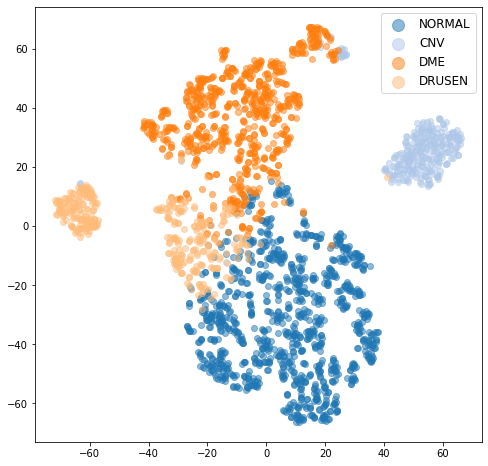

In [83]:
from matplotlib import cm
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 4
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label =  idx_to_label[lab] ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

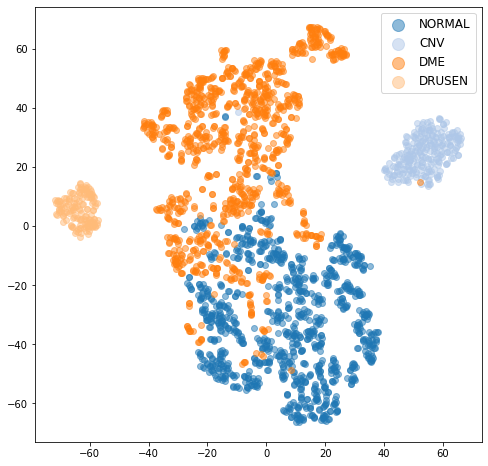

In [84]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 4
for lab in range(num_categories):
    indices = test_targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label =  idx_to_label[lab] ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2454 samples in 0.467s...
[t-SNE] Computed neighbors for 2454 samples in 18.401s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2454
[t-SNE] Computed conditional probabilities for sample 2000 / 2454
[t-SNE] Computed conditional probabilities for sample 2454 / 2454
[t-SNE] Mean sigma: 0.868132
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.321022
[t-SNE] KL divergence after 1000 iterations: 0.780537


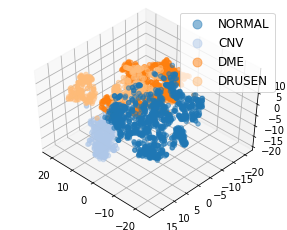

In [85]:
from mpl_toolkits.mplot3d import Axes3D

tsne = TSNE(3, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
cmap = cm.get_cmap('tab20')
fig = plt.figure(1, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
num_categories = 4
for lab in range(num_categories):
    indices = test_predictions == lab
    ax.scatter(tsne_proj[indices, 0],
               tsne_proj[indices, 1],
               tsne_proj[indices, 2],
               c=np.array(cmap(lab)).reshape(1, 4),
               label=idx_to_label[lab],
               alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

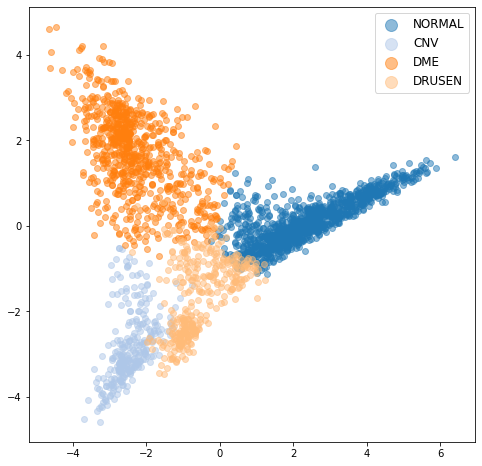

In [86]:

pca = PCA(n_components=2)
pca.fit(test_embeddings)
pca_proj = pca.transform(test_embeddings)
pca.explained_variance_ratio_
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 4
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(pca_proj[indices,0],pca_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = idx_to_label[lab] ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

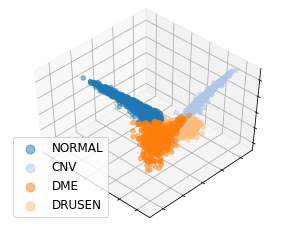

In [87]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca.fit(test_embeddings)
pca_proj = pca.transform(test_embeddings)
pca.explained_variance_ratio_
cmap = cm.get_cmap('tab20')
# fig, ax = plt.subplots(figsize=(8,8))
fig = plt.figure(1, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
num_categories = 4
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(pca_proj[indices,0],pca_proj[indices,1],pca_proj[indices,2],label = idx_to_label[lab],c=np.array(cmap(lab)).reshape(1,4)
           ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

## Grad-Cam

### Grad-CAM, Grad-CAM++ and Score-CAM implementation in Pytorch

https://github.com/jacobgil/pytorch-grad-cam

### Captum

#### Widget

In [16]:
! pip install flask_compress

     |████████████████████████████████| 358kB 5.2MB/s 


In [82]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature
from captum.attr import visualization as viz
from captum.attr import GuidedGradCam

def baseline_func(input):
    return input * 0

def formatted_data_iter():
    dataset = oct_data
    dataloader = iter(
        torch.utils.data.DataLoader(dataset.oct_test, batch_size=4, shuffle=False, num_workers=32)
    )
    while True:
        images, labels = next(dataloader)
        yield Batch(inputs=images, labels=labels)

classes = ('NORMAL',
           'CNV',
           'DME',
           'DRUSEN')


visualizer = AttributionVisualizer(
    models=[model_tuned],
    score_func=lambda o: torch.nn.functional.softmax(0, 1),
    classes=classes,
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[transform],
        )
    ],
    dataset=formatted_data_iter(),
)

In [ ]:
visualizer.render(debug=False)

CaptumInsights(insights_config={'classes': ('NORMAL', 'CNV', 'DME', 'DRUSEN'), 'methods': ['Deconvolution', 'D…

#### Still Image

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:55: UserWarning:

Input Tensor 0 did not already require gradients, required_grads has been set automatically.

/usr/local/lib/python3.7/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning:

Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



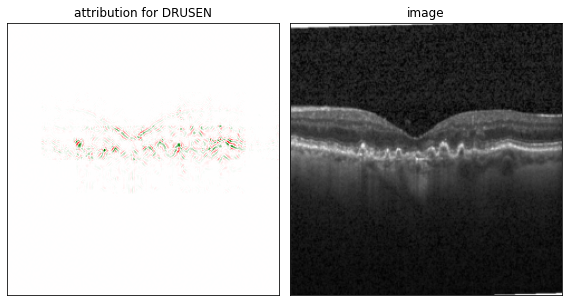

In [20]:
from PIL import Image
from captum.attr import GuidedGradCam
from captum.attr import visualization as viz

center_crop = transforms.Compose([
 transforms.Resize((244, 244)),
 transforms.Grayscale(num_output_channels=3),
])

vis_types = ["heat_map", "original_image"]
vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both

img = Image.open('/content/drive/MyDrive/Colab_Notebooks/OCT_Scans/OCT2017_M/test/DRUSEN-1173253-1.jpeg')

input = transform(img)
input = input.unsqueeze(0)

guided_gc = GuidedGradCam(model_tuned, model_tuned.base_model.encoder.layer4)
attribution = guided_gc.attribute(input.cpu(), 3)

attribution_cnv = np.transpose(attribution.squeeze().cpu().detach().numpy(), (1,2,0))

_ = viz.visualize_image_attr_multiple(attribution_cnv,
                                      np.array(center_crop(img)),
                                      vis_types,
                                      vis_signs,
                                      ["attribution for DRUSEN", "image"],
                                      show_colorbar = False
                                     )

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:55: UserWarning:

Input Tensor 0 did not already require gradients, required_grads has been set automatically.



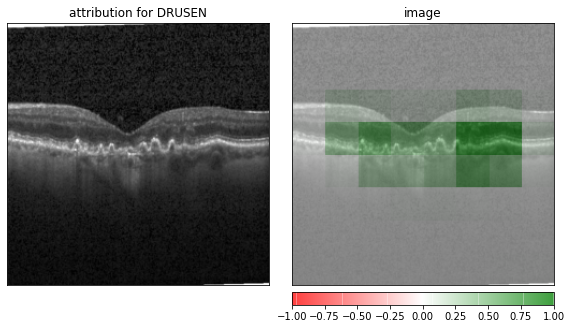

(244, 244, 3)

In [91]:
from PIL import Image
from captum.attr import GuidedGradCam, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

center_crop = transforms.Compose([
 transforms.Resize((244, 244)),
 transforms.Grayscale(num_output_channels=3),
])

vis_types = ["original_image", "blended_heat_map"]
vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both

img = Image.open('/content/drive/MyDrive/Colab_Notebooks/OCT_Scans/OCT2017_M/test/DRUSEN-1173253-1.jpeg')

input = transform(img)
input = input.unsqueeze(0)

layer_gc = LayerGradCam(model_tuned, model_tuned.base_model.encoder.layer4[-1])
attribution = layer_gc.attribute(input.cpu(), 3)

upsampled_attr = LayerAttribution.interpolate(attribution, (244, 244))

upsampled_attr = np.transpose(upsampled_attr.squeeze(0).cpu().detach().numpy(), (1,2,0))

_ = viz.visualize_image_attr_multiple(upsampled_attr,
                                      np.array(center_crop(img)),
                                      vis_types,
                                      vis_signs,
                                      ["attribution for DRUSEN", "image"],
                                      show_colorbar = True
                                     )

np.array(center_crop(img)).shape

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:55: UserWarning:

Input Tensor 0 did not already require gradients, required_grads has been set automatically.

/usr/local/lib/python3.7/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning:

Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



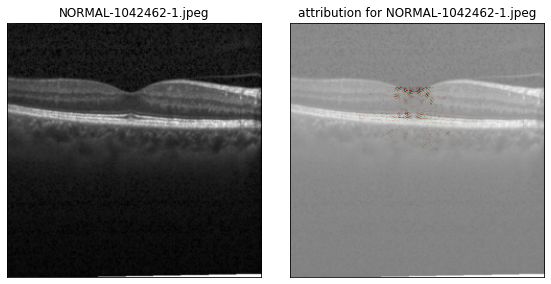

In [81]:
from PIL import Image
from captum.attr import GuidedGradCam
from captum.attr import visualization as viz

center_crop = transforms.Compose([
 transforms.Resize((244, 244)),
 transforms.Grayscale(num_output_channels=3),
])

vis_types = ["original_image", "blended_heat_map"]
vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both

oct_scan = "NORMAL-1042462-1.jpeg"
# oct_scan = "DME-3810791-1.jpeg"
# oct_scan = "CNV-5674369-3.jpeg"
# oct_scan = "DRUSEN-1173253-1.jpeg"

img = Image.open('/content/drive/MyDrive/Colab_Notebooks/OCT_Scans/OCT2017_M/test/' + oct_scan)

input = transform(img)
input = input.unsqueeze(0)

guided_gc = GuidedGradCam(model_tuned, 
                          model_tuned.base_model.encoder.layer4[-1])

attribution = guided_gc.attribute(input.cpu(), 0)

attribution_cnv = np.transpose(attribution.squeeze().cpu().detach().numpy(), (1,2,0))

_ = viz.visualize_image_attr_multiple(attribution_cnv,
                                      np.array(center_crop(img)),
                                      vis_types,
                                      vis_signs,
                                      [oct_scan, "attribution for " + oct_scan],
                                      show_colorbar = False
                                     )

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:55: UserWarning:

Input Tensor 0 did not already require gradients, required_grads has been set automatically.



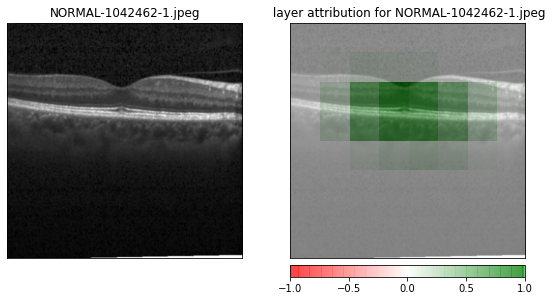

(244, 244, 3)

In [139]:
from PIL import Image
from captum.attr import GuidedGradCam, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

center_crop = transforms.Compose([
 transforms.Resize((244, 244)),
 transforms.Grayscale(num_output_channels=3),
])

vis_types = ["original_image", "blended_heat_map"]
vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both

oct_scan = "NORMAL-1042462-1.jpeg"
# oct_scan = "DME-3810791-1.jpeg"
# oct_scan = "CNV-5674369-3.jpeg"
# oct_scan = "DRUSEN-1173253-1.jpeg"

img = Image.open('/content/drive/MyDrive/Colab_Notebooks/OCT_Scans/OCT2017_M/test/' + oct_scan)

input = transform(img)
input = input.unsqueeze(0)

layer_gc = LayerGradCam(model_tuned, model_tuned.base_model.encoder.layer4[-1])
attribution = layer_gc.attribute(input.cpu(), 0)

upsampled_attr = LayerAttribution.interpolate(attribution, (244, 244))

upsampled_attr = np.transpose(upsampled_attr.squeeze(0).cpu().detach().numpy(), (1,2,0))

_ = viz.visualize_image_attr_multiple(upsampled_attr,
                                      np.array(center_crop(img)),
                                      vis_types,
                                      vis_signs,
                                      [oct_scan, " layer attribution for " + oct_scan],
                                      show_colorbar = True
                                     )

In [164]:
#explore dataset
total_test = pd.read_csv(f"{root_dir}/test.csv")
total_test.head()

,image_id,label
0,CNV-1016042-1.jpeg,1
1,CNV-1016042-2.jpeg,1
2,CNV-1016042-3.jpeg,1
3,CNV-1016042-4.jpeg,1
4,CNV-103044-1.jpeg,1


/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:55: UserWarning:

Input Tensor 0 did not already require gradients, required_grads has been set automatically.

/usr/local/lib/python3.7/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning:

Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



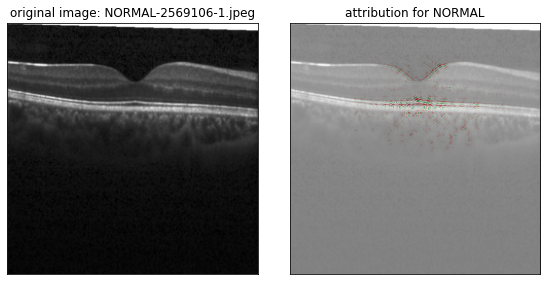

In [198]:
import random
from PIL import Image
from captum.attr import GuidedGradCam
from captum.attr import visualization as viz

center_crop = transforms.Compose([
 transforms.Resize((244, 244)),
 transforms.Grayscale(num_output_channels=3),
])

vis_types = ["original_image", "blended_heat_map"]
vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both

rand_idx = random.randint(0, total_test.shape[0])

oct_scan = total_test.image_id[rand_idx]
label = total_test.label[rand_idx]

img = Image.open('/content/drive/MyDrive/Colab_Notebooks/OCT_Scans/OCT2017_M/test/' + oct_scan)

input = transform(img)
input = input.unsqueeze(0)

guided_gc = GuidedGradCam(model_tuned, 
                          model_tuned.base_model.encoder.layer4)

attribution = guided_gc.attribute(input.cpu(), int(label))

attribution = np.transpose(attribution.squeeze().cpu().detach().numpy(), (1,2,0))

_ = viz.visualize_image_attr_multiple(attribution,
                                      np.array(center_crop(img)),
                                      vis_types,
                                      vis_signs,
                                      ['original image: ' + oct_scan, 
                                       "attribution for " + classes[label]],
                                      show_colorbar = False
                                     )

In [1]:
from PIL import Image
from captum.attr import GuidedGradCam
from captum.attr import visualization as viz

vis_types = ["original_image", "blended_heat_map"]
vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both

rand_idx = random.randint(0, total_test.shape[0])

oct_scan = total_test.image_id[rand_idx]
label = total_test.label[rand_idx]

classes = ('NORMAL',
           'CNV',
           'DME',
           'DRUSEN')

img = Image.open('/content/drive/MyDrive/Colab_Notebooks/OCT_Scans/OCT2017_M/test/' + oct_scan)

input = transform(img)
input = input.unsqueeze(0)

layer_gc = LayerGradCam(model_tuned, 
                          model_tuned.base_model.encoder.layer4)

attribution = layer_gc.attribute(input.cpu(), int(label))

upsampled_attr = LayerAttribution.interpolate(attribution, (244, 244))

upsampled_attr = np.transpose(upsampled_attr.squeeze(0).cpu().detach().numpy(), 
                              (1,2,0))

_ = viz.visualize_image_attr_multiple(upsampled_attr,
                                      np.array(center_crop(img)),
                                      vis_types,
                                      vis_signs,
                                      ['original image: ' + oct_scan, 
                                       "attribution for " + classes[label]],
                                      show_colorbar = True
                                     )

ModuleNotFoundError: ignored

# Serve Model

In [ ]:
!pip install flask-ngrok
!pip install flask==0.12.2  # Newer versions of flask don't work in Colab
!pip install Werkzeug==0.16.1

In [ ]:
import io
import json

import torchvision.transforms as transforms
from PIL import Image
from flask import Flask, jsonify, request
from flask_ngrok import run_with_ngrok


app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run
# imagenet_class_index = json.load(open('drive/My Drive/imagenet_class_index.json'))
oct_class_index = {
    0: 'NORMAL',
    1: 'CNV',
    2: 'DME',
    3: 'DRUSEN'
}
model_loaded.eval()


def transform_image(image_bytes):
    my_transforms = transforms.Compose([
      transforms.Grayscale(num_output_channels=3),
      transforms.Resize((244, 244)),
      transforms.ToTensor(),
      # ImageNet Normalization
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
    ])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)


def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    outputs = model_loaded.forward(tensor)
    _, y_hat = outputs.max(1)
    predicted_idx = int(y_hat.item())
    return predicted_idx,oct_class_index[predicted_idx]


@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        file = request.files['file']
        img_bytes = file.read()
        class_id, class_name = get_prediction(image_bytes=img_bytes)
        return jsonify({'class_id': class_id, 'class_name': class_name})

@app.route("/")
def info():
    return "Serving up pytorch model"

if __name__ == '__main__':
    app.run()